# SIR Simulation and Solution Comparison
## November 23rd, 2022
### Overview: In this notebook, I create a stochastic simulation of a disease propagating through a population and compare its SIR curves with solutions to the SIR ODE system. I also incorporate quarantine and vaccination factors into the ODE system and plot the solution curves to these.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint, solve_ivp

In [2]:
class person:
    def __init__(self,id,state):
        # numerical indicator of person
        self.id = id
        
        #state will either be susceptible: 0, incubating: 1, infectious: 2, recovered: 3, dead: 4
        self.state = state
        
        #time spent incubating the disease
        self.incubated = 0
        
        #time spent infected
        self.infected = -1
    
    def connect(self,connections):
        #list of people (class objects) that person comes in contact with
        self.connections = connections
    
    def incubate_update(self,incubation_time):
        #boolean to determine whether or not person has gone from incubator to infectious
        inf = False
        
        #if incubating, inc time spent incubating
        if self.state == 1:
            self.incubated += 1
            
            #if incubated for the entire incubation period 
            if self.incubated > incubation_time:
                #become infectious and reset incubation time
                self.state = 2
                self.incubated = 0
                inf = True
        
        return inf
                
    def infectious_update(self,infectious_time):
        #boolean to determine whether or not person has gone from infectious to recovered
        rec = False 
        
        #if infectious, inc time spent infectious
        if self.state == 2:
            self.infected += 1
            
            #draw from gaussian to determine whether recover
            draw = np.random.normal(loc=4.)
            if draw >= 4 - self.infected:
                #become recovered and reset infected time
                self.state = 3
                self.infected = 0
                rec = True
            
            
            
            #if infected for the entire infection period 
            #if self.infected == infectious_time-1:
            #    #become recovered and reset infected time
            #    self.state = 3
            #    self.infected = 0
            #    rec = True
        
        return rec
    
    def stochastic_transmit(self,other,prob):
        #if this person is infectious and the other is susceptible
        if self.state == 2:
            if other.state == 0:
    
                #decide whether a transmission will take place; boolean
                transmit = np.random.binomial(1,prob)
                
                if transmit: 
                    other.state = 1
                    return other.id
            
    def stochastic_infect_all(self,prob):
        to_incubate = []
        for other in self.connections:
            
            new = self.stochastic_transmit(other,prob)
            if new is not None: to_incubate.append(new)
                
        return to_incubate
    
    def stochastic_death(self,mortality_rate):
        die = np.random.binomial(1,mortality_rate)
        
        if die:
            self.state = 4
            return self.id
            
    def __str__(self):
        return "person " + str(self.id) + ":\tstate: " + str(self.state) + ", incubated: " + str(self.incubated) + " days"

In [3]:
class disease:
    def __init__(self,infection_rate,incubation_time,infectious_time,mortality_rate):
        self.infection_rate = infection_rate
        self.incubation_time = incubation_time
        self.infectious_time = infectious_time
        self.mortality_rate = mortality_rate

In [4]:
class world:
    def __init__(self,N,N_I,disease,approx_avg_connections):
        #save parameters: population Number, Number_Infected, and infection rate
        self.N = N
        self.N_I = N_I
        self.disease = disease
        self.approx_avg_connections = approx_avg_connections
        
        #Susceptible, incubating, Infected, Recovered, and Dead, respectively
        self.S = dict()
        self.i = dict()
        self.I = dict()
        self.R = dict()
        self.D = dict()
        
        #randomly creating connections between people
        self.world_connections = {i:set() for i in range(N)}
        for i in range(N):
            options = [i for i in range(i)]+[i for i in range(i+1,N)]
            #assuming the max number of people infected will be around a 5th of the total pop, min being 1 contact
            #if max_connections is None: max_connections = N//5 
            contacts= set(np.random.choice(options,np.random.choice(range(1,approx_avg_connections)),replace=False))
            
            #connect via index
            for con in contacts:
                self.world_connections[con] = self.world_connections[con].union({i})
            self.world_connections[i] = self.world_connections[i].union(contacts)
        
        #populate the world
        self.population = dict()
        for ind in range(N):
            
            if ind < N_I:
                per = person(ind,2)
                self.population[ind] = per
                self.I[ind] = per
            else:
                per = person(ind,0)
                self.population[ind] = per
                self.S[ind] = per
        
        #connect the people
        for ind in range(N):
            self.population[ind].connect({self.population[conn] for conn in self.world_connections[ind]})
            
    def update_world(self):
        #for each infected perwson
        infecteds = list(self.I.keys())
        for infected_id in infecteds:
            
            #give them a chance to infect all of their connections; get list of people with successful transmission
            to_incubate = self.population[infected_id].stochastic_infect_all(self.disease.infection_rate)
            
            #remove all the successfully-transmitted-to people from susceptible population; add to incubating population
            for incub_id in to_incubate:
                self.i[incub_id] = self.S.pop(incub_id)
            
            #update infection time of person; if they recover,
            if self.population[infected_id].infectious_update(self.disease.infectious_time):
                #remove person from infected population, add to recovered population
                self.R[infected_id] = self.I.pop(infected_id)
            
            #give person chance to die
            if infected_id in self.I.keys():
                dead = self.population[infected_id].stochastic_death(self.disease.mortality_rate)
                if dead is not None:
                    self.D[infected_id] = self.I.pop(infected_id)
        
        #for each incubator
        incubators = list(self.i.keys())
        for incubator_id in incubators:
            
            #update incubation time of person; if they have completely incubated,
            if self.population[incubator_id].incubate_update(self.disease.incubation_time):
                #remove them from incubation population, add to infected population
                self.I[incubator_id] = self.i.pop(incubator_id)
                
        return len(self.S), len(self.i), len(self.I), len(self.R), len(self.D)
    
    def plot(self,days=None,first=True,opaque=True):
        #restart world
        self.__init__(self.N,self.N_I,self.disease, self.approx_avg_connections)
        
        #lists to hold the number of people in each population
        nS, ni, nI, nR, nD = [len(self.S)], [len(self.i)], [len(self.I)], [len(self.R)], [len(self.D)]
        
        #if time is not specified, run until infected population hits 0
        if days is None:
            while len(self.I) != 0 or len(self.i) != 0:
                #update the world, append pop numbers to each list
                S,i,I,R,D = self.update_world()
                nS.append(S)
                ni.append(i)
                nI.append(I)
                nR.append(R)
                nD.append(D)
                
        #otherwise only run for that many number of days
        else:
            for day in range(days):
                S,i,I,R,D = self.update_world()
                nS.append(S)
                ni.append(i)
                nI.append(I)
                nR.append(R)
                nD.append(D)
        
        #plot results
        if opaque: alph = 1
        else: alph = 0.2
        plt.rcParams["figure.figsize"] = (20,10) #make plots big
        plt.rcParams.update({'font.size': 22})
        T = np.arange(len(nS))
        plt.plot(T,nS,color='firebrick',label='Susceptible',marker="o",alpha=alph)
        if self.disease.incubation_time != 0:
            plt.plot(T,ni,color='cornflowerblue',label='Incubating',marker="o",alpha=alph)
        plt.plot(T,nI,color='midnightblue',label='Infected',marker="o",alpha=alph)
        plt.plot(T,nR,color='forestgreen',label='Recovered',marker="o",alpha=alph)
        if self.disease.mortality_rate != 0:
            plt.plot(T,nD,color='k',label='Dead',marker="o",alpha=alph)
        
        if self.disease.incubation_time != 0 and self.disease.mortality_rate != 0:
            plt.title('Infection Rate: '+str(self.disease.infection_rate)+', Incubation Time: '+ \
                  str(self.disease.incubation_time) + ' days, Average Infection Time: '+str(self.disease.infectious_time) \
                      + " days, Mortality Rate: "+str(self.disease.mortality_rate))
        else:
            plt.title('SIR and Stochastic Model: Infection Rate: '+str(self.disease.infection_rate) + \
                      ', Average Infection Time: '+str(self.disease.infectious_time))
        if first:
            plt.xlabel('Days')
            plt.ylabel('Population')
            plt.legend()
        #plt.show()
        return nS,ni,nI,nR,nD
    
    def __str__(self):
        return 'sus: '+str(len(w.S))+'\nincub: '+str(len(w.i))+'\ninfected: '+str(len(w.I))+'\nrecovered: '+str(len(w.R))

In [5]:
d = disease(infection_rate=.3,incubation_time=5,infectious_time=14,mortality_rate=0.05)
w = world(1000,1,d,approx_avg_connections=10)
print(w)

sus: 999
incub: 0
infected: 1
recovered: 0


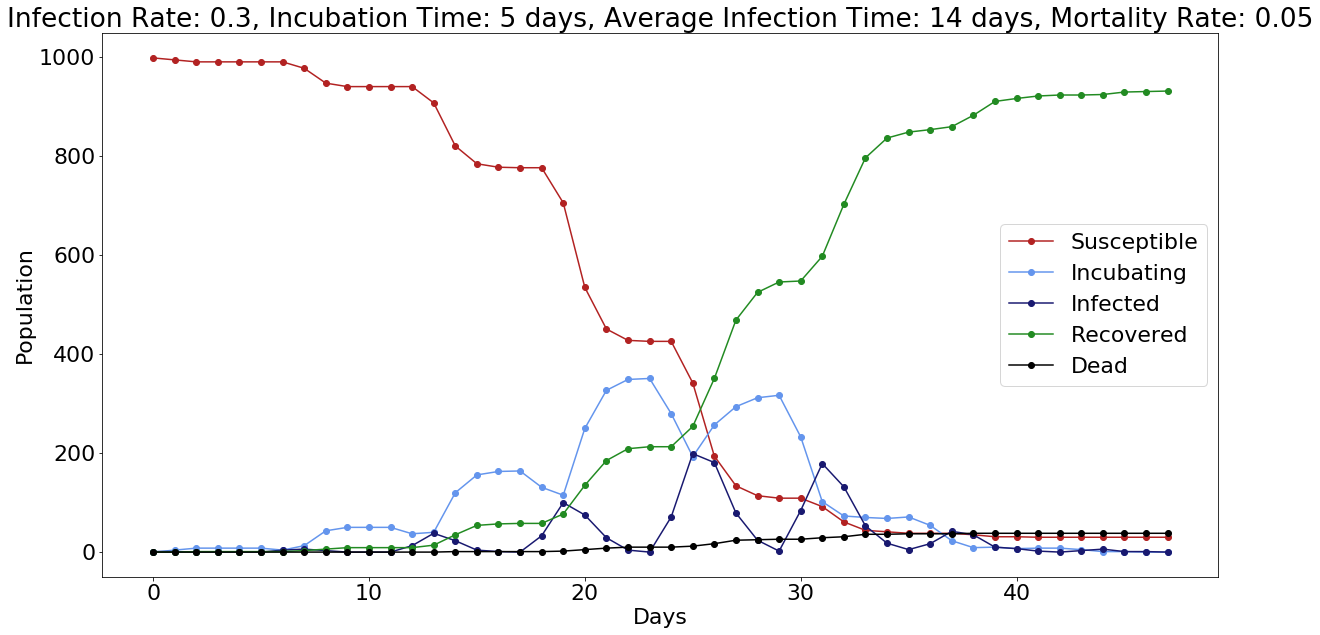

In [6]:
# example simulation with low infection rate, medium incubation time, and long infection time
nS,ni,nI,nR,nD = w.plot()

In [7]:
def basic_sir(b,γ,S0,I0):
    def ode(t,y):
        return np.array([
            -b*y[1]*y[0],
            b*y[1]*y[0] - γ*y[1],
            γ*y[1]
        ])
    y0 = np.array([S0,I0,0])/(S0+I0)
    sol = solve_ivp(ode,(1,50),y0,t_eval=np.arange(1,8.025,0.025))
    plt.rcParams["figure.figsize"] = (20,10) #make plots big
    plt.rcParams.update({'font.size': 22})
    plt.plot(sol.t,1000*sol.y[0],color='r',label='S(t)')
    plt.plot(sol.t,1000*sol.y[1],color='b',label='I(t)')
    plt.plot(sol.t,1000*sol.y[2],color='g',label='R(t)') 
    plt.title('Basic SIR: Infection Rate: 0.5, Average Infection Time: 4 days')
    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.legend()
    plt.show()
    return sol

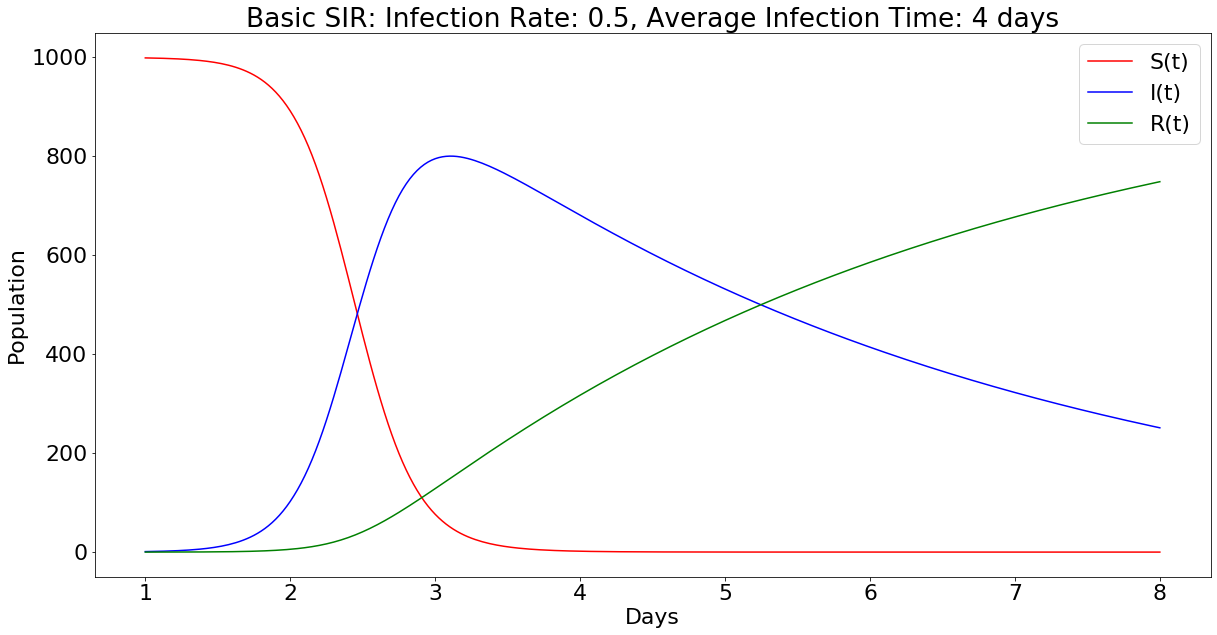

In [8]:
sol = basic_sir(20/4,0.25,999,1)

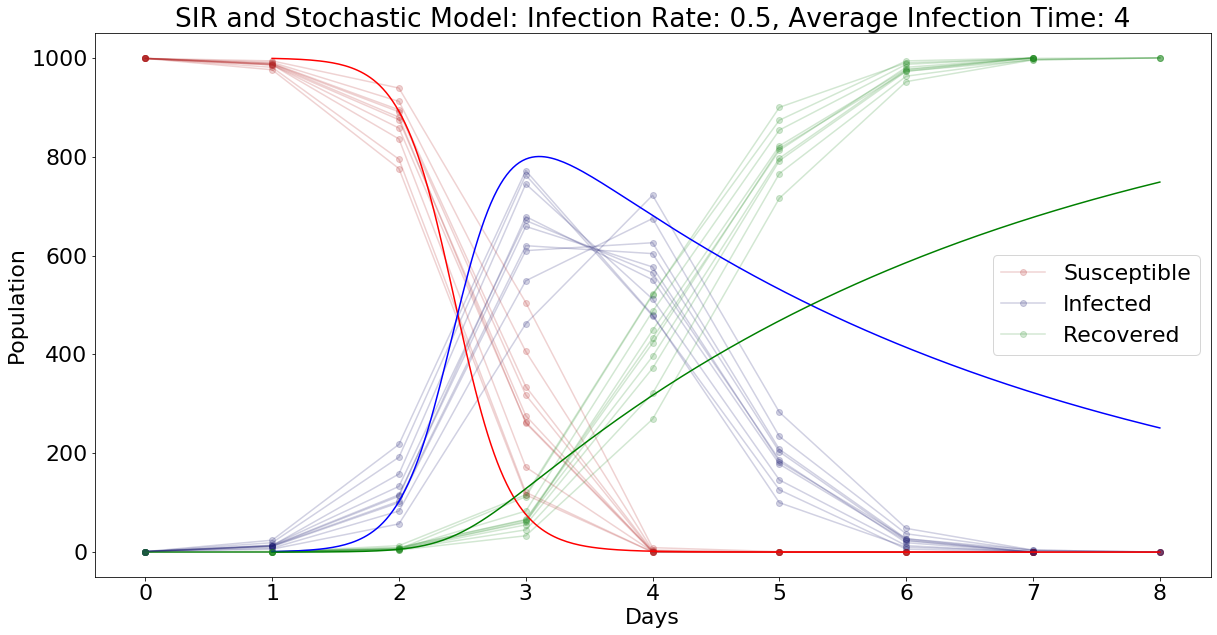

In [9]:
for _ in range(10):
    d = disease(infection_rate=.5,incubation_time=0,infectious_time=4,mortality_rate=0.)
    w = world(1000,1,d,approx_avg_connections=20)
    if _ == 0: nS,ni,nI,nR,nD = w.plot(opaque=False)
    else: nS,ni,nI,nR,nD = w.plot(first=False,opaque=False)
plt.plot(sol.t,1000*sol.y[0],color='r',label='S(t)')
plt.plot(sol.t,1000*sol.y[1],color='b',label='I(t)')
plt.plot(sol.t,1000*sol.y[2],color='g',label='R(t)') 
plt.show()

# As can be seen throughout many different crude stochastic simulations, the SIR solution curves do produce comparable behavior. The limitations of this presentation come from the weaknesses of the simulation I have built preventing it from being extremely realistic. Nevertheless, the similarities are evident.

# Below are implementations of the SIR model with quarantine, vaccination, and combined effects.

In [10]:
def quarantine_sir(b,γ,c,S0,I0):
    def ode(t,y):
        return np.array([
            -b*y[1]*y[0],
            b*y[1]*y[0] - (γ+c)*y[1],
            c*y[1] - γ*y[2],
            γ*(y[1] + y[2])
        ])
    y0 = np.array([S0,I0,0,0])/(S0+I0)
    sol = solve_ivp(ode,(1,50),y0,t_eval=np.arange(1,8.025,0.025))
    plt.rcParams["figure.figsize"] = (20,10) #make plots big
    plt.rcParams.update({'font.size': 22})
    plt.plot(sol.t,1000*sol.y[0],color='r',label='S(t)')
    plt.plot(sol.t,1000*sol.y[1],color='b',label='I(t)')
    plt.plot(sol.t,1000*sol.y[2],color='deeppink',label='Q(t)') 
    plt.plot(sol.t,1000*sol.y[3],color='g',label='R(t)') 
    plt.title('Basic SIQR: Infection Rate: 0.5, Average Infection Time: 4 days, Rate of Quarantine Transition: 1')
    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.legend()
    plt.show()

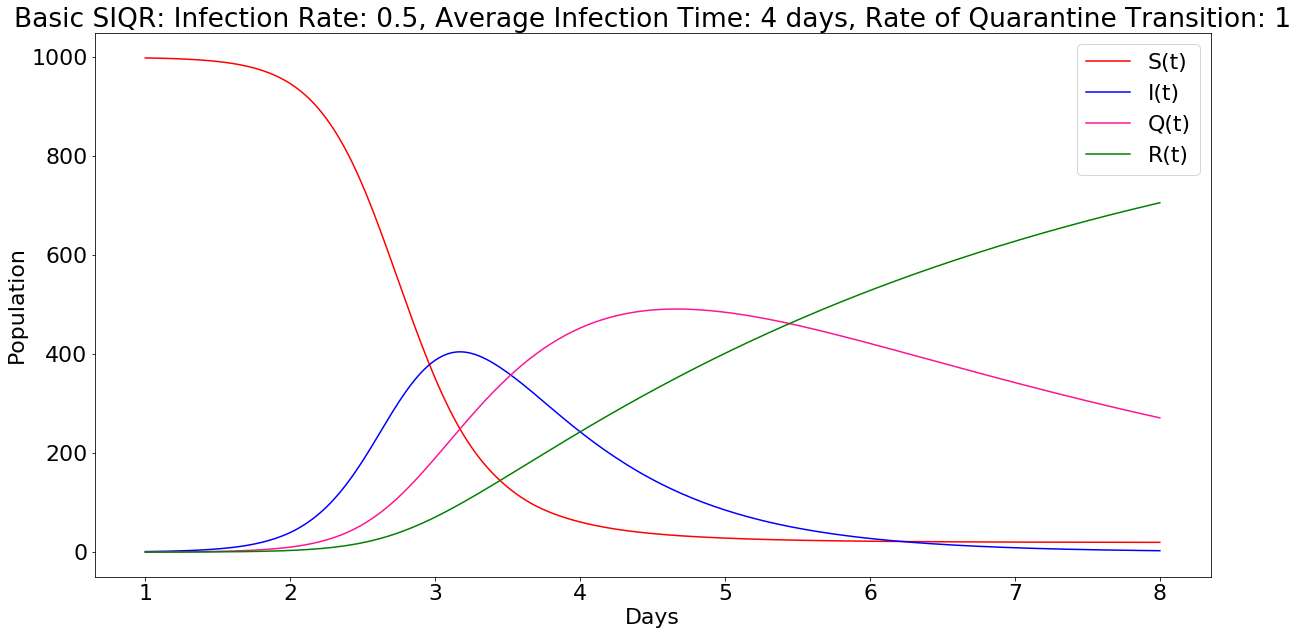

In [11]:
quarantine_sir(5,0.25,1,999,1)

In [12]:
def vaccination_sir(b,γ,v,S0,I0):
    def ode(t,y):
        return np.array([
            -b*y[1]*y[0] - v*y[0],
            b*y[1]*y[0] - γ*y[1],
            γ*y[1] + v*y[0]
        ])
    y0 = np.array([S0,I0,0])/(S0+I0)
    sol = solve_ivp(ode,(1,50),y0,t_eval=np.arange(1,8.025,0.025))
    plt.rcParams["figure.figsize"] = (20,10) #make plots big
    plt.rcParams.update({'font.size': 22})
    plt.plot(sol.t,1000*sol.y[0],color='r',label='S(t)')
    plt.plot(sol.t,1000*sol.y[1],color='b',label='I(t)')
    plt.plot(sol.t,1000*sol.y[2],color='g',label='R(t)') 
    plt.title('Basic SIR with Vaccination: Infection Rate: 0.5, Average Infection Time: 4 days, Vaccination Rate: 0.25')
    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.legend()
    plt.show()

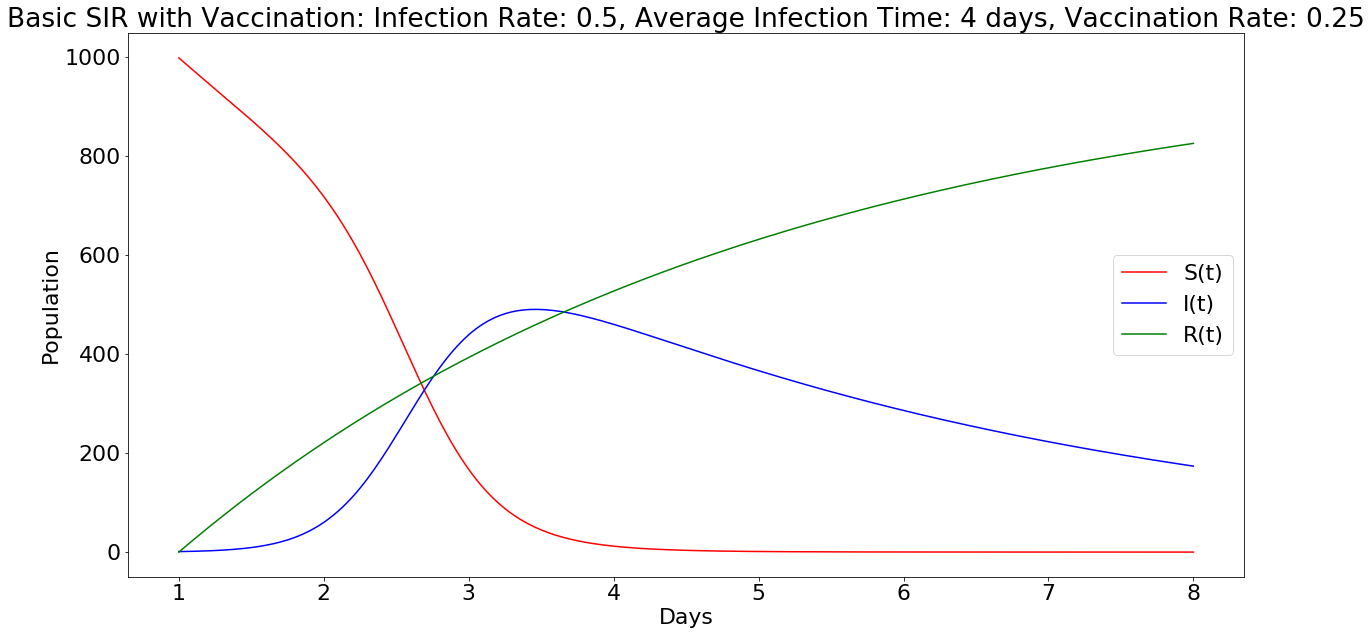

In [13]:
vaccination_sir(5,0.25,0.25,999,1)

In [14]:
def QV_sir(b,γ,c,v,S0,I0):
    def ode(t,y):
        return np.array([
            -b*y[1]*y[0] - v*y[0],
            b*y[1]*y[0] - (γ+c)*y[1],
            c*y[1] - γ*y[2],
            γ*(y[1] + y[2]) + v*y[0]
        ])
    y0 = np.array([S0,I0,0,0])/(S0+I0)
    sol = solve_ivp(ode,(1,50),y0,t_eval=np.arange(1,8.025,0.025))
    plt.rcParams["figure.figsize"] = (20,10) #make plots big
    plt.rcParams.update({'font.size': 22})
    plt.plot(sol.t,1000*sol.y[0],color='r',label='S(t)')
    plt.plot(sol.t,1000*sol.y[1],color='b',label='I(t)')
    plt.plot(sol.t,1000*sol.y[2],color='deeppink',label='Q(t)') 
    plt.plot(sol.t,1000*sol.y[3],color='g',label='R(t)') 
    plt.title('SIQR with Vaccination: Infection Rate: 0.5, Average Infection Time: 4 days, Rate of Quarantine Transition: 1')
    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.legend()
    plt.show()

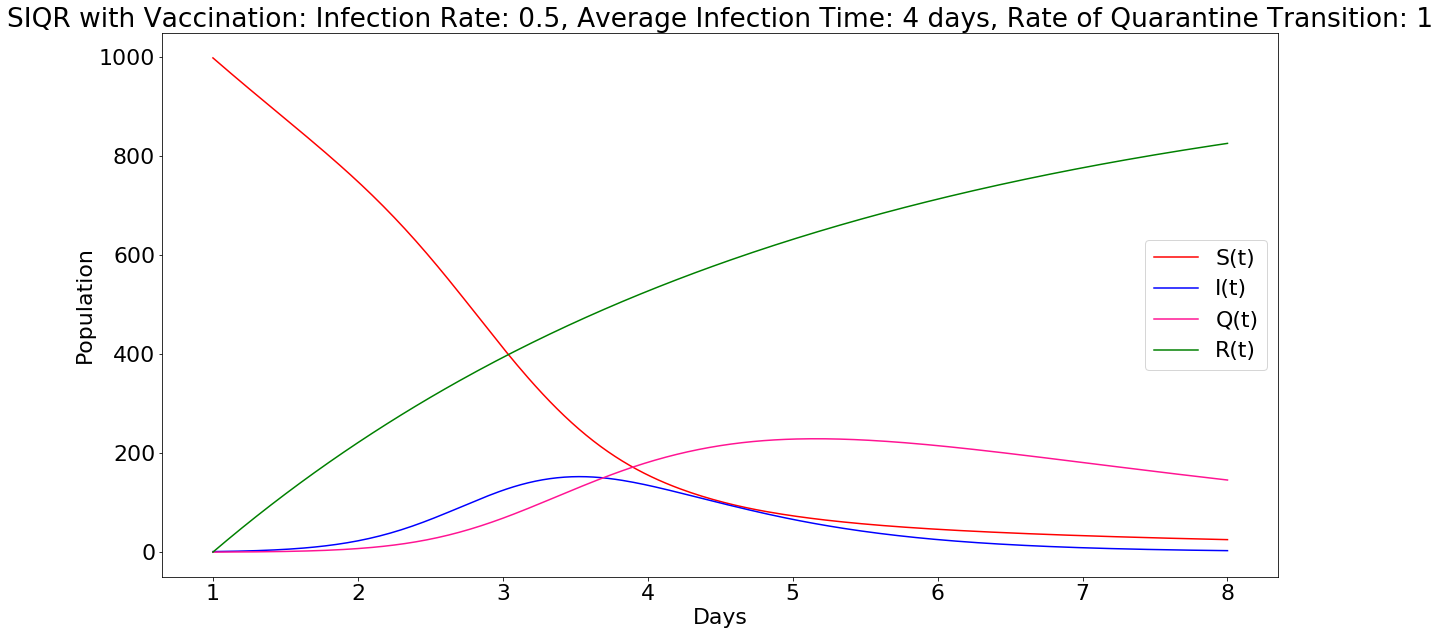

In [15]:
QV_sir(5,0.25,1,0.25,999,1)

# If anyone is looking through this file, I encourage you to play around with different disease and world parameters in the simulation. It was quite fun to make.